## 初始化

### 调包

In [1]:
import sys
import os
import time
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from tqdm import tqdm
import camb
from camb import model, initialpower
import warnings 
warnings.filterwarnings('ignore')
sys.path.append("/home/chenzy/code/")
import illustris_python as il
import h5py
from scipy.spatial import KDTree

### 常数定义

In [2]:
basePath_tng100="/home/cossim/IllustrisTNG/TNG100-1/"
particle_dm_mass=0.00050557*10**10
boxlen_100=75000 #ckpc/h
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

### 读数据

In [3]:
#Halos
#Group中第一个subhalo对应的坐标
GroupFirstSub=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="GroupFirstSub")
#Group的坐标 ckpc/h
GroupPos=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="GroupPos")
#Group的速度 km/s/a
GroupVel=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="GroupVel")
#mass 200   10^10 M_sun/h
Group_M_Mean200=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="Group_M_Mean200")
# R mean 200 ckpc/h
Group_R_Mean200=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="Group_R_Mean200")


#subhalo
#subhalo的坐标 ckpc/h
SubhaloPos=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloPos")
#subhalo是否可靠
SubhaloFlag=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloFlag")
#subhalo 的速度 km/s
SubhaloVel=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloVel")
# all mass
SubhaloMass=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloMass")
# mass type
SubhaloMassType=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloMassType")
SubhaloMass_Star=SubhaloMassType[:,4]

#offset file
f = h5py.File("/home/cossim/IllustrisTNG/TNG100-1/postprocessing/offsets/offsets_099.hdf5", "r")
pid_group=f["Group/SnapByType"][:]
pid_subhalo=f["Subhalo/SnapByType"][:]
parttype_id={"gas":0,"dm":1,"star":4}



## offset file 

In [4]:

# 在halo粒子表中， subhalo的粒子label
def get_pid_group_subhalo(subgroup_id, group_id, parttype="dm"):
    
    return [pid_subhalo[subgroup_id,parttype_id[parttype]]-pid_group[group_id,parttype_id[parttype]],
            pid_subhalo[subgroup_id+1,parttype_id[parttype]]-pid_group[group_id,parttype_id[parttype]]]
#对于一个group获得其subhalo的ID
def get_subhaloID(GroupID):
    if GroupFirstSub[GroupID]==-1:
        return 0
    return np.arange(GroupFirstSub[GroupID],GroupFirstSub[GroupID+1])


In [5]:
def turn_label_tick(label_ticks, imshow_ticks):
#label_ticks, 在哪些地方放标签
#imshow_ticks, 0，1，2.。。。对应的值
    y=interpolate.interp1d(imshow_ticks, np.arange(len(imshow_ticks))-0.5)
    label_str=["%.1f" % number for number in label_ticks]
    
    return y(label_ticks), label_str

def plot_v_r_2d_hist_q(ax, r_bins, v_bins, r, v, q, vmax=0.8, vmin=0.6, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1,1,10], v_ticks=[-1000,-100,0,100,1000]):
    N, v_edge, r_edge=np.histogram2d(v, r, bins=[ v_bins, r_bins], )
    q_mean,v_edge, r_edge=np.histogram2d(v, r, bins=[v_bins, r_bins], weights=q)
    q_mean=q_mean/N
    
    image=ax.imshow(q_mean, origin="lower",vmax=vmax, vmin=vmin)
    cb=plt.colorbar(image, ax=ax)
    cb.set_label('q=b/a') 

    label_loc_r, label_str_r=turn_label_tick(label_ticks=r_ticks, imshow_ticks=r_bins)
    ax.set_xticks(label_loc_r)
    ax.set_xticklabels(label_str_r)
    ax.set_xlabel(xlabel)
    label_loc_v, label_str_v=turn_label_tick(label_ticks=v_ticks, imshow_ticks=v_bins)
    ax.set_yticks(label_loc_v)
    ax.set_yticklabels(label_str_v)
    ax.set_ylabel(ylabel)
    #return q_mean, (r_edge[1:]+r_edge[:-1])/2, (v_edge[1:]+v_edge[:-1])/2

def plot_v_r_2d_hist_N(ax, r_bins, v_bins, r, v, vmax=3, vmin=0, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1,1,10], v_ticks=[-1000,-100,0,100,1000]):
    N, v_edge, r_edge=np.histogram2d(v, r, bins=[ v_bins, r_bins], )
    
    image = ax.imshow(np.log10(N/(4*np.pi*(r_edge[1:]/2+r_edge[:-1]/2)**2)), origin="lower",vmax=vmax, vmin=vmin)
    cb=plt.colorbar(image, ax=ax)
    cb.set_label('np.log10(N)')
    
    label_loc_r, label_str_r=turn_label_tick(label_ticks=r_ticks, imshow_ticks=(r_edge[1:]+r_edge[:-1])/2)
    ax.set_xticks(label_loc_r)
    ax.set_xticklabels(label_str_r)
    ax.set_xlabel(xlabel)
    label_loc_v, label_str_v=turn_label_tick(label_ticks=v_ticks, imshow_ticks=(v_edge[1:]+v_edge[:-1])/2)
    ax.set_yticks(label_loc_v)
    ax.set_yticklabels(label_str_v)
    ax.set_ylabel(ylabel)
    #return q_mean, (r_edge[1:]+r_edge[:-1])/2, (v_edge[1:]+v_edge[:-1])/2

def plot_v_r_2d_hist_N(ax, r_bins, v_bins, r, v, vmax=3, vmin=0, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1,1,10], v_ticks=[-1000,-100,0,100,1000]):
    N, v_edge, r_edge=np.histogram2d(v, r, bins=[ v_bins, r_bins], )
    
    
    image = ax.imshow(np.log10(N/(4*np.pi*(r_edge[1:]/2+r_edge[:-1]/2)**2)), origin="lower",vmax=vmax, vmin=vmin)
    cb=plt.colorbar(image, ax=ax)
    cb.set_label('np.log10(N)')
    
    label_loc_r, label_str_r=turn_label_tick(label_ticks=r_ticks, imshow_ticks=(r_edge[1:]+r_edge[:-1])/2)
    ax.set_xticks(label_loc_r)
    ax.set_xticklabels(label_str_r)
    ax.set_xlabel(xlabel)
    label_loc_v, label_str_v=turn_label_tick(label_ticks=v_ticks, imshow_ticks=(v_edge[1:]+v_edge[:-1])/2)
    ax.set_yticks(label_loc_v)
    ax.set_yticklabels(label_str_v)
    ax.set_ylabel(ylabel)
    #return q_mean, (r_edge[1:]+r_edge[:-1])/2, (v_edge[1:]+v_edge[:-1])/2




# 筛选出星系

In [15]:
label1 = np.where(SubhaloMass_Star>-1)[0]
label2 = np.where((SubhaloMass_Star>0)&(SubhaloFlag!=0))[0]
print(len(label1),len(label2), len(SubhaloMass_Star))

4371211 327324 4371211


Text(0, 0.5, 'N')

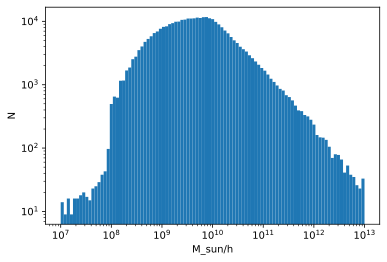

In [9]:
bins = 10**np.linspace(7,13,100)
label = np.where((SubhaloMass_Star>0)&(SubhaloFlag!=0))[0]
plt.hist(SubhaloMass[label]*10**10, bins=bins)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("M_sun/h")
plt.ylabel("N")


In [10]:
SubhaloMass[label1]

array([2.7477936e+04, 3.6666228e+03, 7.7345551e+02, ..., 1.1180036e-02,
       1.0721726e-02, 1.1700135e-02], dtype=float32)

# 2d e1, e2

In [14]:
#在考虑循环边界条件的情况下计算粒子间的距离
def get_pos_diff(pos_a,pos_b,boxlen):
    diff1=pos_b-pos_a
    diff2=pos_b-pos_a
    diff2[np.where(np.abs(diff1)>boxlen/2)]=diff1[np.where(np.abs(diff1)>boxlen/2)]-np.sign(diff1[np.where(np.abs(diff1)>boxlen/2)])*boxlen
    return diff2

# step 1. get I

# step2 turn I into e1, e2


In [6]:
N_subhalo=len(SubhaloFlag)
partType="star"
boxlen=boxlen_100
subgroup_I_star=np.zeros((N_subhalo, 3, 3))
subgroup_N_star=np.zeros((N_subhalo))
subgroup_belong=np.zeros((N_subhalo))
#label = []
for i in tqdm(range(0, 20000)):
    #get subgroups in this group 
    subgroup_id=get_subhaloID(GroupID=i)
    # if there is no subgroup in this halo, then skip it
    if type(subgroup_id)==int:
        continue
        
    #read particle position, mass in this group (for I)
    particle_pos_group=il.snapshot.loadHalo(basePath=basePath_tng100, snapNum=99, id=i, partType=partType, fields="Coordinates")
    particle_mass_group=il.snapshot.loadHalo(basePath=basePath_tng100, snapNum=99, id=i, partType=partType, fields="Masses")
    
    if type(particle_pos_group) == dict:
        continue
    
    for j in (subgroup_id):
        if (SubhaloMass_Star[j]<=0) or (SubhaloFlag[j]==0):
            continue
       
        l1,l2=get_pid_group_subhalo(subgroup_id=j, group_id=i, parttype=partType)
        
            
        # particles in this subgroup
        particle_pos = particle_pos_group[l1:l2,:]
        particle_mass= particle_mass_group[l1:l2]
        
        pos_diff=get_pos_diff(pos_a=SubhaloPos[j,:],pos_b=particle_pos,boxlen=boxlen)
        I=np.zeros((3,3))
        for ii in range(3):
            for jj in range(3):
                I[ii,jj]=np.sum(particle_mass*pos_diff[:,ii]*pos_diff[:,jj])/np.sum(particle_mass)
        subgroup_I_star[j,:,:]=I
        subgroup_N_star[j] = l2-l1
        subgroup_belong[j] = i+1   # =0, means it dose not belong to any halo

100%|██████████| 20000/20000 [21:37<00:00, 15.42it/s] 


In [7]:
label = np.where(subgroup_N_star>0)[0]
np.savez("test_2D_I.npz", I = subgroup_I_star[label], N_star=subgroup_N_star[label],
        belong = subgroup_belong[label], label=label)

Text(0, 0.5, 'N')

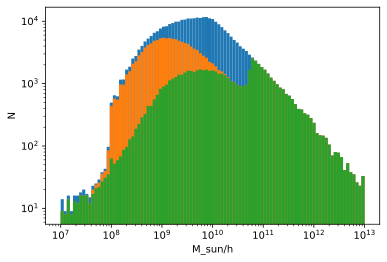

In [13]:
label1=np.where(subgroup_N_star>10)[0]
label2=np.where(subgroup_N_star>0)[0]
bins = 10**np.linspace(7,13,100)
label3 = np.where((SubhaloMass_Star>0)&(SubhaloFlag!=0))[0]
plt.hist(SubhaloMass[label3]*10**10, bins=bins)
plt.hist(SubhaloMass[label2]*10**10, bins=bins)
plt.hist(SubhaloMass[label1]*10**10, bins=bins)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("M_sun/h")
plt.ylabel("N")



In [22]:
np.where(subgroup_belong==0)

(array([      0,       1,       2, ..., 4371208, 4371209, 4371210]),)

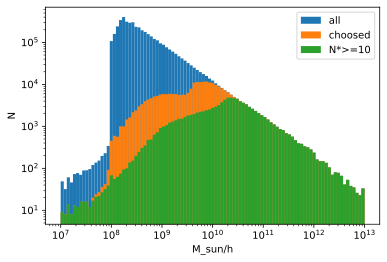

In [26]:
bins = 10**np.linspace(7,13,100)

d=np.load("test_2D_I.npz")
N_star_min=10
label = d["label"]
subgroup_N_star=d["N_star"]


ll = np.where(subgroup_N_star>=N_star_min)[0]

plt.hist(SubhaloMass*10**10, bins=bins, label="all")
plt.hist(SubhaloMass[label]*10**10, bins=bins, label="choosed")
plt.hist(SubhaloMass[label[ll]]*10**10, bins=bins, label="N*>=10")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("M_sun/h")
plt.ylabel("N")
plt.legend()

In [15]:
# read prepared data from file 
d=np.load("test_2D_I.npz")
N_star_min=5
M_star_min=10**10/10**10
label = d["label"]
subgroup_N_star=d["N_star"]
subgroup_I_star=d["I"]
subgroup_belong=d["belong"]

ll = np.where((subgroup_N_star>=N_star_min)&(SubhaloMass[label]>=M_star_min))[0]

label = label[ll]
subgroup_N_star = subgroup_N_star[ll]
subgroup_I_star = subgroup_I_star[ll]
subgroup_belong = subgroup_belong[ll]
del d, ll, N_star_min

In [29]:
len(label), len(SubhaloMass)

(83173, 4371211)

## turn I into e1, e2

In [16]:
#label=np.where((subgroup_I_star[:,0,0]>0)&(subgroup_N_star>10))[0]
eigenvalue=np.zeros((len(label),3))
eigenvector=np.zeros((len(label),3,3))
for i in tqdm(range(len(label))):
    I=subgroup_I_star[i, :,:]

    ww, vv =np.linalg.eig(I)
    ll=(np.argsort(ww)[::-1])
    eigenvector[i,:,:]=vv[:,ll]
    eigenvalue[i,:]=ww[ll]
np.min(eigenvalue)

100%|██████████| 83173/83173 [00:02<00:00, 29078.88it/s]


0.00022016103197735736

In [19]:
def turn_I_into_e(value, vector, proj="x",label=0):
    if proj == "x":
        s_perp=vector[1:,:]
        s_para=vector[0,:]
    if proj == "y":
        s_perp=vector[[0,2],:]
        s_para=vector[1,:]
    if proj == "z":
        s_perp=vector[[0,1],:]
        s_para=vector[2,:]
    
    
    alpha2=0
    k=np.zeros(2)
    W_=np.zeros((2,2))
    for i in [0,1,2]:
        alpha2+=s_para[i]**2/value[i]**2
        
        k[0]+=s_para[i]*s_perp[0,i]/value[i]**2
        k[1]+=s_para[i]*s_perp[1,i]/value[i]**2
        
        W_[0,0]+=s_perp[0,i]*s_perp[0,i]/value[i]**2
        W_[0,1]+=s_perp[0,i]*s_perp[1,i]/value[i]**2
        W_[1,0]+=s_perp[1,i]*s_perp[0,i]/value[i]**2
        W_[1,1]+=s_perp[1,i]*s_perp[1,i]/value[i]**2
        
    W_[0,0]-=k[0]*k[0]/alpha2
    W_[1,0]-=k[1]*k[0]/alpha2
    W_[0,1]-=k[0]*k[1]/alpha2
    W_[1,1]-=k[1]*k[1]/alpha2
    #print(W_, s_perp)
    
    W=np.linalg.inv(W_)
    
    e1=(W[0,0]-W[1,1])/(W[0,0]+W[1,1]+2*np.sqrt(np.linalg.det(W)))
    e2=2*W[0,1]/(W[0,0]+W[1,1]+2*np.sqrt(np.linalg.det(W)))
    #print((W[0,0]-W[1,1]), 2*W[0,1], np.sqrt(np.linalg.det(W)))
    if e1>-100:
        
        return np.array([e1,e2])
    else:
        #print(label, e1)
        return np.array([e1,e2])

In [20]:
ex=np.zeros((len(label), 2))
ey=np.zeros((len(label), 2))
ez=np.zeros((len(label), 2))



#tan1=[]
#tan2=[]
#subhalo_choose_flag=np.where(SubhaloMass>1)[0]
for i in tqdm(range(len(label))):
    
    ex[i,:]=turn_I_into_e(value=eigenvalue[i,:],vector=eigenvector[i,:,:], proj="x",label=i)
    ey[i,:]=turn_I_into_e(value=eigenvalue[i,:],vector=eigenvector[i,:,:], proj="y",label=i)
    ez[i,:]=turn_I_into_e(value=eigenvalue[i,:],vector=eigenvector[i,:,:], proj="z",label=i)
    
    

100%|██████████| 83173/83173 [00:13<00:00, 6134.84it/s]


In [ ]:
plt.hist(e_len)
np.mean(e_len)

In [55]:
v_200

array([946.7911 , 955.9791 , 892.94714, ...,       nan,       nan,
             nan], dtype=float32)

In [21]:
v_200 = 6.56*np.sqrt(Group_M_Mean200/(Group_R_Mean200/1000))
ex_len = np.sqrt(ex[:,0]**2+ex[:,1]**2)
ey_len = np.sqrt(ey[:,0]**2+ey[:,1]**2)
ez_len = np.sqrt(ez[:,0]**2+ez[:,1]**2)



In [22]:
r_bins=10**np.linspace(-1, 1.6, 40)
v_bins=np.linspace(-2.5,2.5, 40)

r_max = 10*10**3 #kMpc/h

group_labels = range(2000)
r_all = []
r_x_all = []
r_y_all = []
r_z_all = []
v_para_all = []
ex_len_all = []
ey_len_all = []
ez_len_all = []
submass_all = []

cos_theta_x_all = []
cos_theta_y_all = []
cos_theta_z_all = []

for i in tqdm(group_labels): #group
    
    r_=get_pos_diff(pos_a=GroupPos[i,:],pos_b=SubhaloPos[label],boxlen=boxlen_100) #b-a
    r_len_=np.linalg.norm(r_, axis=1)
    
    
    ll = np.where(r_len_<r_max)[0]
    r_ = r_[ll, :]
    r_len_ = r_len_[ll]
    
    #if len(ll)%100 == 0 :
    #    print(len(ll))
    
    r_len_x=np.linalg.norm(r_[:,[1,2]], axis=1)
    r_len_y=np.linalg.norm(r_[:,[0,2]], axis=1)
    r_len_z=np.linalg.norm(r_[:,[0,1]], axis=1)
    
    cos_theta_x = np.sum(r_[:, [1,2]] * ex[ll,:], axis=1)/r_len_x/ex_len[ll]
    cos_theta_y = np.sum(r_[:, [0,2]] * ey[ll,:], axis=1)/r_len_y/ey_len[ll]
    cos_theta_z = np.sum(r_[:, [0,1]] * ez[ll,:], axis=1)/r_len_z/ez_len[ll]
    
    v_=SubhaloVel[label[ll],:]-GroupVel[i,:]
    v_para_ = np.sum(r_*v_,axis=1)/r_len_/v_200[i]
    
    
    r_all = np.hstack([r_all, r_len_/Group_R_Mean200[i]])
    v_para_all = np.hstack([v_para_all, v_para_])
    ex_len_all = np.hstack([ex_len_all, ex_len[ll]])
    ey_len_all = np.hstack([ey_len_all, ey_len[ll]])
    ez_len_all = np.hstack([ez_len_all, ez_len[ll]])
    
    cos_theta_x_all = np.hstack([cos_theta_x_all, cos_theta_x])
    cos_theta_y_all = np.hstack([cos_theta_y_all, cos_theta_y])
    cos_theta_z_all = np.hstack([cos_theta_z_all, cos_theta_z])
    
    r_x_all = np.hstack([r_x_all, r_len_x/Group_R_Mean200[i]])
    r_y_all = np.hstack([r_y_all, r_len_y/Group_R_Mean200[i]])
    r_z_all = np.hstack([r_z_all, r_len_z/Group_R_Mean200[i]])
    
    submass_all = np.hstack([submass_all, SubhaloMass[label[ll]]])
    
    #break


100%|██████████| 2000/2000 [01:04<00:00, 31.04it/s]


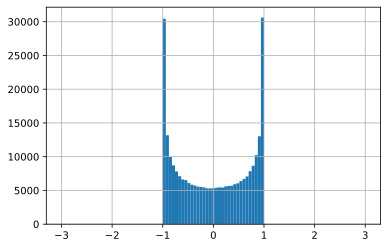

In [85]:
plt.hist(cos_theta_z_all, bins=np.linspace(-3, 3, 100))
plt.grid()

In [ ]:
np.savez("test_2D_stack_20000.npz", r_all = r_all, 
r_x_all = r_x_all,
r_y_all = r_y_all,
r_z_all = r_z_all,
v_para_all = v_para_all,
ex_len_all = ex_len_all,
ey_len_all = ey_len_all,
ez_len_all = ez_len_all,
submass_all = submass_all,
cos_theta_x_all = cos_theta_x_all,
cos_theta_y_all = cos_theta_y_all,
cos_theta_z_all = cos_theta_z_all)

In [40]:
d = np.load("test_2D_stack_20000.npz")
r_all = d["r_all"] 
r_x_all = d["r_x_all"]
r_y_all = d["r_y_all"]
r_z_all = d["r_z_all"]
v_para_all = d["v_para_all"]
ex_len_all = d["ex_len_all"]
ey_len_all = d["ey_len_all"]
ez_len_all = d["ez_len_all"]
submass_all = d["submass_all"]
cos_theta_x_all = d["cos_theta_x_all"]
cos_theta_y_all = d["cos_theta_y_all"]
cos_theta_z_all = d["cos_theta_z_all"]

In [29]:
d = np.load("test_2D_stack_20000.npz")
r_all = d["r_all"] 
r_x_all = d["r_x_all"]
r_y_all = d["r_y_all"]
r_z_all = d["r_z_all"]
v_para_all = d["v_para_all"]
ex_len_all = d["ex_len_all"]
ey_len_all = d["ey_len_all"]
ez_len_all = d["ez_len_all"]
submass_all = d["submass_all"]
cos_theta_x_all = d["cos_theta_x_all"]
cos_theta_y_all = d["cos_theta_y_all"]
cos_theta_z_all = d["cos_theta_z_all"]


r_200_all = d["r_200_all"]/1000
v_200_all = d["v_200_all"]
sin_theta_x_all = d["sin_theta_x_all"]
sin_theta_y_all = d["sin_theta_y_all"]
sin_theta_z_all = d["sin_theta_z_all"]

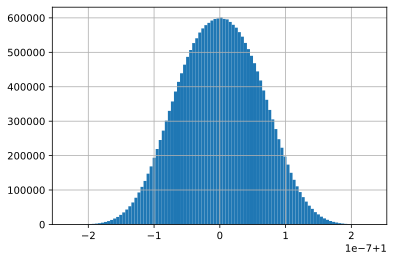

In [31]:
plt.hist(cos_theta_x_all**2+sin_theta_x_all**2, bins=100)
plt.grid()

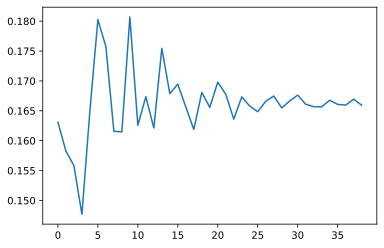

In [28]:
a = np.hstack([r_all,r_all,r_all])
b = np.hstack([cos_theta_x_all**2-1/3, cos_theta_y_all**2-1/3,cos_theta_z_all**2-1/3])

a=a[np.where(b>-100)]
b=b[np.where(b>-100)]

w = np.histogram(a, bins=r_bins, weights = b)[0]
N = np.histogram(a, bins=r_bins)[0]
plt.plot(w/N)


In [24]:
def show_stack(weights, label="", vmin=-0.1, vmax=0.1):
    r_bins=10**np.linspace(-1, 1.6, 40)
    v_bins=np.linspace(-2.8,2.8, 40)
    e_mean = np.histogram2d(np.hstack([v_para_all, v_para_all, v_para_all]), 
                        np.hstack([r_x_all, r_y_all, r_z_all]), 
                        bins = [v_bins, r_bins], 
                        weights = weights)[0]
    N = np.histogram2d(np.hstack([v_para_all, v_para_all, v_para_all]), 
                   np.hstack([r_x_all,r_y_all,r_z_all]), bins = [v_bins, r_bins])[0]

    fig, ax =plt.subplots()
    plt.imshow(e_mean/N, origin="lower",vmin=vmin, vmax=vmax)
    cb = plt.colorbar()
    cb.ax.set_ylabel(label)

    r_ticks = [0.1,1,10]
    v_ticks = [-2, -1, 0, 1, 2]
    xlabel="$r_\perp/r_{200}$"
    ylabel="V_para/V_200"
    label_loc_r, label_str_r=turn_label_tick(label_ticks=r_ticks, imshow_ticks=r_bins)
    ax.set_xticks(label_loc_r)
    ax.set_xticklabels(label_str_r)
    ax.set_xlabel(xlabel)

    label_loc_v, label_str_v=turn_label_tick(label_ticks=v_ticks, imshow_ticks=v_bins)
    ax.set_yticks(label_loc_v)
    ax.set_yticklabels(label_str_v)
    ax.set_ylabel(ylabel)

In [8]:
def show_stack_norm(weights, label="", vmin=-0.1, vmax=0.1):
    r_bins=10**np.linspace(-1, 1.6, 40)
    v_bins=np.linspace(-2.8,2.8, 40)
    e_mean = np.histogram2d(np.hstack([v_para_all/v_200_all, v_para_all/v_200_all, v_para_all/v_200_all,]), 
                        np.hstack([r_x_all/r_200_all,r_y_all/r_200_all,r_z_all/r_200_all]), 
                        bins = [v_bins, r_bins], 
                        weights = weights)[0]
    N = np.histogram2d(np.hstack([v_para_all/v_200_all, v_para_all/v_200_all, v_para_all/v_200_all,]), 
                   np.hstack([r_x_all/r_200_all,r_y_all/r_200_all,r_z_all/r_200_all]), bins = [v_bins, r_bins])[0]

    fig, ax =plt.subplots()
    plt.imshow(e_mean/N, origin="lower",vmin=vmin, vmax=vmax)
    cb = plt.colorbar()
    cb.ax.set_ylabel(label)

    r_ticks = [0.1,1,10]
    v_ticks = [-2, -1, 0, 1, 2]
    xlabel="$r_\perp/r_{200}$"
    ylabel="V_para/V_200"
    label_loc_r, label_str_r=turn_label_tick(label_ticks=r_ticks, imshow_ticks=r_bins)
    ax.set_xticks(label_loc_r)
    ax.set_xticklabels(label_str_r)
    ax.set_xlabel(xlabel)

    label_loc_v, label_str_v=turn_label_tick(label_ticks=v_ticks, imshow_ticks=v_bins)
    ax.set_yticks(label_loc_v)
    ax.set_yticklabels(label_str_v)
    ax.set_ylabel(ylabel)

In [37]:
np.mean(cos_theta_x_all), np.mean(cos_theta_z_all**2), np.mean(ex_len_all), ex_len_all

(0.0013079562835379161,
 0.4996934068371977,
 0.39219125499370866,
 array([0.10775301, 0.13245249, 0.36418412, ..., 0.29007827, 0.75502842,
        0.56532333]))

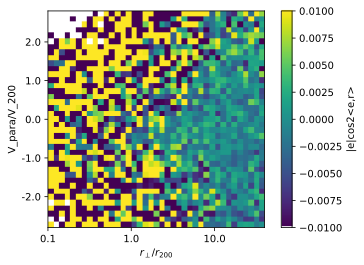

In [26]:
show_stack(weights= np.hstack([ex_len_all*(2*cos_theta_x_all**2-1), 
                                    ey_len_all*(2*cos_theta_y_all**2-1),ez_len_all*(2*cos_theta_z_all**2-1)]), 
           label="|e|cos2<e,r>", vmin=-0.01, vmax=0.01)

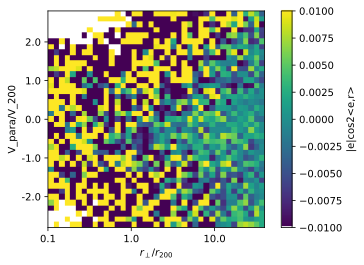

In [11]:
show_stack_norm(weights= np.hstack([ex_len_all*(2*cos_theta_x_all*sin_theta_x_all),
                               ey_len_all*(2*cos_theta_y_all*sin_theta_y_all),
                               ez_len_all*(2*cos_theta_z_all*sin_theta_z_all)]), 
           label="|e|cos2<e,r>", vmin=-0.01, vmax=0.01)

(-0.000424418111688437, 0.707118933499978)

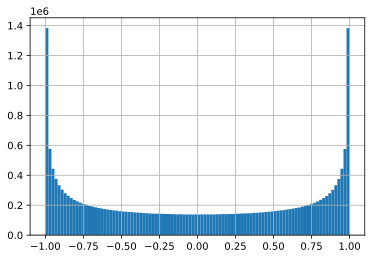

In [75]:
plt.hist(2*cos_theta_x_all**2-1, bins=100)
plt.grid()
np.mean(2*cos_theta_x_all[np.where(cos_theta_x_all>-100)]**2-1), np.std(2*cos_theta_x_all[np.where(cos_theta_x_all>-100)]**2-1)

Text(0, 0.5, 'V_para/V_200')

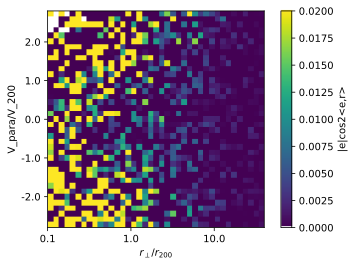

In [77]:
r_bins=10**np.linspace(-1, 1.6, 40)
v_bins=np.linspace(-2.8,2.8, 40)
del e_mean
e_mean = np.histogram2d(np.hstack([v_para_all, v_para_all, v_para_all,]), np.hstack([r_x_all,r_y_all,r_z_all]), bins = [v_bins, r_bins], 
                        weights = np.hstack([ex_len_all*(2*cos_theta_x_all**2-1), 
                                             ey_len_all*(2*cos_theta_y_all**2-1),
                                             ez_len_all*(2*cos_theta_z_all**2-1)]))[0]
N = np.histogram2d(np.hstack([v_para_all, v_para_all, v_para_all,]), np.hstack([r_x_all,r_y_all,r_z_all]), bins = [v_bins, r_bins])[0]
fig, ax =plt.subplots()
plt.imshow(e_mean/N,  origin="lower",vmin=0, vmax=0.02)
cb = plt.colorbar()
cb.ax.set_ylabel("|e|cos2<e,r>")

r_ticks = [0.1,1,10]
v_ticks = [-2, -1, 0, 1, 2]
xlabel="$r_\perp/r_{200}$"
ylabel="V_para/V_200"
label_loc_r, label_str_r=turn_label_tick(label_ticks=r_ticks, imshow_ticks=r_bins)
ax.set_xticks(label_loc_r)
ax.set_xticklabels(label_str_r)
ax.set_xlabel(xlabel)

label_loc_v, label_str_v=turn_label_tick(label_ticks=v_ticks, imshow_ticks=v_bins)
ax.set_yticks(label_loc_v)
ax.set_yticklabels(label_str_v)
ax.set_ylabel(ylabel)


#level=[0.4, 0.41, 0.42, 0.425]
#CS2=ax.contour(e_mean/N,level,colors=["w","r","m","b"],linewidths=2)


Text(0, 0.5, 'V_para/V_200')

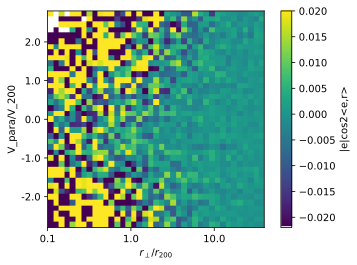

In [72]:
r_bins=10**np.linspace(-1, 1.6, 40)
v_bins=np.linspace(-2.8,2.8, 40)
del e_mean
e_mean = np.histogram2d(np.hstack([v_para_all, v_para_all, v_para_all,]), np.hstack([r_x_all,r_y_all,r_z_all]), bins = [v_bins, r_bins], 
                        weights = np.hstack([ex_len_all*(cos_theta_x_all), 
                                             ey_len_all*(cos_theta_y_all),
                                             ez_len_all*(cos_theta_z_all)]))[0]
N = np.histogram2d(np.hstack([v_para_all, v_para_all, v_para_all,]), np.hstack([r_x_all,r_y_all,r_z_all]), bins = [v_bins, r_bins])[0]
fig, ax =plt.subplots()
plt.imshow(e_mean/N,  origin="lower",vmin=0.02, vmax=-0.02)
cb = plt.colorbar()
cb.ax.set_ylabel("|e|cos2<e,r>")

r_ticks = [0.1,1,10]
v_ticks = [-2, -1, 0, 1, 2]
xlabel="$r_\perp/r_{200}$"
ylabel="V_para/V_200"
label_loc_r, label_str_r=turn_label_tick(label_ticks=r_ticks, imshow_ticks=r_bins)
ax.set_xticks(label_loc_r)
ax.set_xticklabels(label_str_r)
ax.set_xlabel(xlabel)

label_loc_v, label_str_v=turn_label_tick(label_ticks=v_ticks, imshow_ticks=v_bins)
ax.set_yticks(label_loc_v)
ax.set_yticklabels(label_str_v)
ax.set_ylabel(ylabel)


#level=[0.4, 0.41, 0.42, 0.425]
#CS2=ax.contour(e_mean/N,level,colors=["w","r","m","b"],linewidths=2)


In [64]:
2*cos_theta_x_all**2-1, cos_theta_x_all

(array([        nan, -0.32718029, -0.68080566, ..., -0.49771267,
        -0.60045777, -0.64717916]),
 array([        nan, -0.5800085 ,  0.39949615, ...,  0.50114236,
        -0.44695762,  0.42001241]))

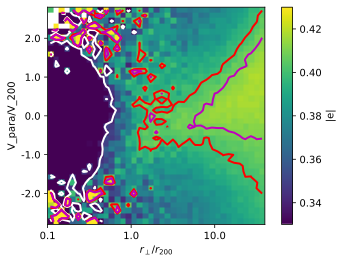

In [35]:
e_mean = np.histogram2d(np.hstack([v_para_all, v_para_all, v_para_all,]), np.hstack([r_x_all,r_y_all,r_z_all]), bins = [v_bins, r_bins],  weights = np.hstack([ex_len_all,ey_len_all,ez_len_all]))[0]
N = np.histogram2d(np.hstack([v_para_all, v_para_all, v_para_all,]), np.hstack([r_x_all,r_y_all,r_z_all]), bins = [v_bins, r_bins])[0]
fig, ax =plt.subplots()
plt.imshow(e_mean/N,  origin="lower",vmin=0.33, vmax=.43)
cb = plt.colorbar()
cb.ax.set_ylabel("|e|")

r_ticks = [0.1,1,10]
v_ticks = [-2, -1, 0, 1, 2]
xlabel="$r_\perp/r_{200}$"
ylabel="V_para/V_200"
label_loc_r, label_str_r=turn_label_tick(label_ticks=r_ticks, imshow_ticks=r_bins)
ax.set_xticks(label_loc_r)
ax.set_xticklabels(label_str_r)
ax.set_xlabel(xlabel)

label_loc_v, label_str_v=turn_label_tick(label_ticks=v_ticks, imshow_ticks=v_bins)
ax.set_yticks(label_loc_v)
ax.set_yticklabels(label_str_v)
ax.set_ylabel(ylabel)


level=[0.34, 0.4,0.41]
CS2=ax.contour(e_mean/N,level,colors=["w","r","m","b"],linewidths=2)



In [67]:
fig, ax=plt.subplots(figsize=(6, 6))
plt.plot(np.hstack([r_x_all,r_y_all,r_z_all]), np.hstack([v_para_all, v_para_all, v_para_all,]), ".k", ms=1, alpha=0.01,rasterized=True)
plt.xlim(r_bins[0], r_bins[-1])
plt.ylim(v_bins[0], v_bins[-1])
level=[0.34, 0.4, 0.41]
#CS2=ax.contour(e_mean/N,level,colors=["r","lightgreen","m","r"],linewidths=1)
ax.contour((r_bins[1:]+r_bins[:-1])/2, (v_bins[1:]+v_bins[:-1])/2, e_mean/N,levels=level,colors=["r","lightgreen","m","r"],linewidths=2,zorder=100)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

plt.xscale("log")
fig.savefig("2.pdf")
plt.close()

In [33]:
len(r_all[::1000])

21699

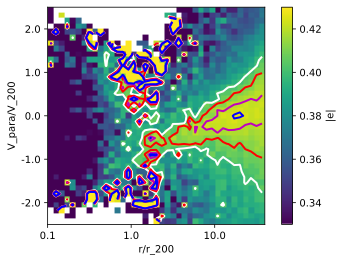

In [99]:
e_mean = np.histogram2d(np.hstack([v_para_all, v_para_all, v_para_all,]), np.hstack([r_all,r_all,r_all]), bins = [v_bins, r_bins], 
                        weights = np.hstack([ex_len_all,ey_len_all,ez_len_all]))[0]
N = np.histogram2d(np.hstack([v_para_all, v_para_all, v_para_all,]), np.hstack([r_all,r_all,r_all]), bins = [v_bins, r_bins])[0]
fig, ax =plt.subplots()
plt.imshow(e_mean/N,  origin="lower",vmin=0.33, vmax=0.43)
cb = plt.colorbar()
cb.ax.set_ylabel("|e|")

r_ticks = [0.1,1,10]
v_ticks = [-2, -1, 0, 1, 2]
xlabel="r/r_200"
ylabel="V_para/V_200"
label_loc_r, label_str_r=turn_label_tick(label_ticks=r_ticks, imshow_ticks=r_bins)
ax.set_xticks(label_loc_r)
ax.set_xticklabels(label_str_r)
ax.set_xlabel(xlabel)

label_loc_v, label_str_v=turn_label_tick(label_ticks=v_ticks, imshow_ticks=v_bins)
ax.set_yticks(label_loc_v)
ax.set_yticklabels(label_str_v)
ax.set_ylabel(ylabel)


level=[0.4, 0.41, 0.42, 0.425]
CS2=ax.contour(e_mean/N,level,colors=["w","r","m","b"],linewidths=2)



Text(0, 0.5, 'lg|M|')

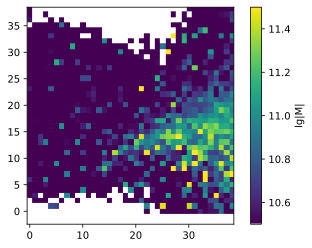

In [93]:
N = np.histogram2d( v_para_all, r_all, bins = [v_bins, r_bins])[0]

M_mean = np.histogram2d( v_para_all, r_all, bins = [v_bins, r_bins], 
                        weights = submass_all)[0]
fig, ax =plt.subplots()
plt.imshow(np.log10(M_mean/N)+10,  origin="lower",vmin=10.5, vmax=11.5)
level = [10.4]
ax.contour((r_bins[1:]+r_bins[:-1])/2, (v_bins[1:]+v_bins[:-1])/2, e_mean/N,levels=level,colors=["r","lightgreen","m","r"],linewidths=2,zorder=100)


cb = plt.colorbar()
cb.ax.set_ylabel("lg|M|")

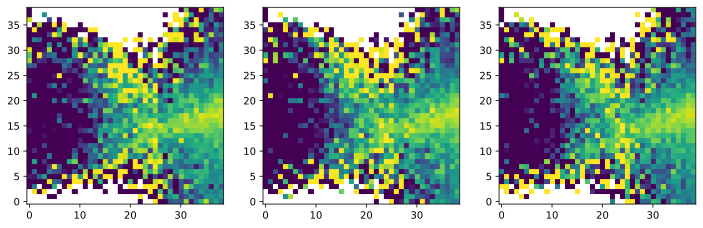

In [77]:
fig, ax  = plt.subplots(1, 3, figsize=(12, 4))
N = np.histogram2d( v_para_all, r_all, bins = [v_bins, r_bins])[0]

e_mean = np.histogram2d( v_para_all, r_all, bins = [v_bins, r_bins], 
                        weights = ex_len_all)[0]
ax[0].imshow(e_mean/N,  origin="lower",vmin=0.33, vmax=0.43)
e_mean = np.histogram2d( v_para_all, r_all, bins = [v_bins, r_bins], 
                        weights = ey_len_all)[0]
ax[1].imshow(e_mean/N,  origin="lower",vmin=0.33, vmax=0.43)
e_mean = np.histogram2d( v_para_all, r_all, bins = [v_bins, r_bins], 
                        weights = ez_len_all)[0]
ax[2].imshow(e_mean/N,  origin="lower",vmin=0.33, vmax=0.43)

In [80]:
fig, ax=plt.subplots(figsize=(6, 6))
plt.plot(r_all[::10], v_para_all[::10], ".k", ms=1, alpha=0.5)
plt.xlim(r_bins[0], r_bins[-1])
plt.ylim(v_bins[0], v_bins[-1])
level=[0.4]
#CS2=ax.contour(e_mean/N,level,colors=["r","lightgreen","m","r"],linewidths=1)
ax.contour((r_bins[1:]+r_bins[:-1])/2, (v_bins[1:]+v_bins[:-1])/2, e_mean/N,levels=level,colors=["r","lightgreen","m","r"],linewidths=2,zorder=100)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

plt.xscale("log")
fig.savefig("2.pdf")
plt.close()